## Librerias a instalar

In [ ]:
! pip install yolov5 gitpython pytorch-lightning torchmetrics torchvision timm

## Imports

In [7]:
from smart_inference import BarcodeInferencer
import git
import sys
import os
import yolov5
import cv2

repo = git.Repo(".", search_parent_directories=True)
base_path = f"{repo.working_tree_dir}/src"
sys.path.append(base_path + '/models' + '/smart_inference')
from preprocess_mdcnn import get_ROI

## Obtención de los dos modelos que actualmente estamos usando

In [8]:
yolo_model_file = os.path.join(base_path, "train", "yolov5_runs", "weights", "5m_1k_30k_3k.pt")
mdcnn_model_file = os.path.join(base_path, "models", "smart_inference", "2021-07-08 19:50:37.323384", "epoch=12-step=26103.ckpt")

## Inferencia con yolo (ejemplo muy naive)

In [9]:
yolo = yolov5.YOLOv5(yolo_model_file, device='cuda')
path = '/home/ec2-user/SageMaker/la-comer/src/data/barcode_decoding_ean13/DetectionDataset4/test/'
yolo_process = True
image_name = sorted(os.listdir(path + 'images'))[1111]
images = []
images.append(cv2.imread(f"{path}images/{image_name}"))
images.append(cv2.imread(f"{path}images/{image_name}"))
frames = []

r = yolo.predict(images)

if yolo_process:
    for frames_found, image in zip(r.xyxy, images):
        x1, y1, x2, y2 = -1, -1, -1, -1
        for i, (x1, y1, x2, y2, confidence, _class) in enumerate(frames_found):
            if confidence > .5:
                xyxy = x1, y1, x2, y2
                frames.append(get_ROI(image, xyxy, 20))
else:
    frames = images

## Inferencia con MDCNN

#### Instanciamos Objeto que hace inferencia
La variable 20 indica que tanto depth se hace en la busqueda de smart inference, si aumenta es más lento pero puede ser más preciso, 20 es buen tradeoff

In [10]:
B = BarcodeInferencer(mdcnn_model_file, 20)

#### Hacemos la inferencia
Recibe un conjunto de frames y un topk, que regresa las k opciones más probables que cumplen checksum (o menos si no encuentra) tantas posibilidades que lo cumplen. Está ordenado de forma que el primero es el más probable

In [11]:
topk = 5 # te da el top_k de opciones
B.smart_inference(frames, 5) 

#### Resultado

In [12]:
B.result_smart_inference

['4210101339305']

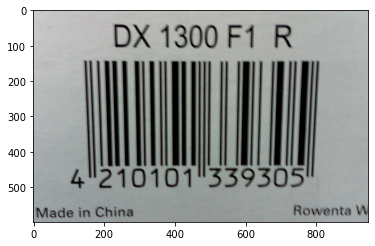

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(frames[0])